# Housekeeping

In [1]:
# gen imports

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)
pd.set_option('display.width', 500)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/RBS DL 2025/PRO/data'

In [4]:
train_test_dtypes = {
    'stock_id': np.uint8,
    'time_id': np.uint16,
    'target': np.float64
}

df_train = pd.read_csv(f'{data_dir}/train.csv', dtype=train_test_dtypes)
df_test = pd.read_csv(f'{data_dir}/test.csv', usecols=['stock_id', 'time_id'], dtype=train_test_dtypes)

print(f'Training Set Shape: {df_train.shape}')
print(f'Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape}')
print(f'Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (428932, 3)
Training Set Memory Usage: 4.50 MB
Test Set Shape: (3, 2)
Test Set Memory Usage: 0.00 MB


## UTILITY FUNCTIONS

In [5]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [6]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return ** 2))

In [7]:
def calculate_wap(df):
    a1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    a2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    b = df['bid_size1'] + df['ask_size1'] + df['bid_size2']+ df['ask_size2']
    return (a1 + a2)/ b

In [8]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] = calculate_wap(df_book_data)
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id', prediction_column_name]]

In [9]:
def past_realized_volatility_per_stock(list_file, prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized, realized_volatility_per_time_id(file, prediction_column_name)])
    return df_past_realized

In [10]:
# def summary_stats():
#     df.columns = [f(x) for x in df.columns]
#     df["volatility1"] = (df["diff_log_wap1_sum"])**0.5
#     df["volatility2"] = (df["diff_log_wap2_sum"])**0.5
#     df["vol1_mean"] = df["diff_log_wap1_mean"].fillna(0).values
#     df["vol2_mean"] = df["diff_log_wap2_mean"].fillna(0).values
#     df["vol1_std"] = df["diff_log_wap1_std"].fillna(0).values
#     df["vol2_std"] = df["diff_log_wap2_std"].fillna(0).values
#     df["vol1_median"] = df["diff_log_wap1_median"].fillna(0).values
#     df["vol2_median"] = df["diff_log_wap2_median"].fillna(0).values
#     df["vol1_max"] = df["diff_log_wap1_max"].fillna(0).values
#     df["vol2_max"] = df["diff_log_wap2_max"].fillna(0).values
#     df["vol1_min"] = df["diff_log_wap1_min"].fillna(0).values
#     df["vol2_min"] = df["diff_log_wap2_min"].fillna(0).values
#     df["volatility_rate"] = (df["volatility1"] / df["volatility2"]).fillna(0)
#     df["mean_volatility_rate"] = (df["vol1_mean"] / df["vol2_mean"]).fillna(0)
#     df["std_volatility_rate"] = (df["vol1_std"] / df["vol2_std"]).fillna(0)
#     df["median_volatility_rate"] = (df["vol1_median"] / df["vol2_median"]).fillna(0)
#     df["max_volatility_rate"] = (df["vol1_max"] / df["vol2_max"]).fillna(0)
#     df["min_volatility_rate"] = (df["vol1_min"] / df["vol2_min"]).fillna(0)

In [11]:
# def bid_ask_spread():
#     df['bas'] = (df[['ask_price1', 'ask_price2']].min(axis = 1)/ df[['bid_price1', 'bid_price2']].max(axis = 1) - 1)

# **Exploratory Data Analysis**

In [12]:
def root_mean_squared_percentage_error(y_true, y_pred, epsilon=1e-10):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + epsilon))))
    return rmspe

In [13]:
target_mean_rmspe = root_mean_squared_percentage_error(df_train['target'], np.repeat(df_train['target'].mean(), len(df_train)))
print(f'target Mean RMPSE: {target_mean_rmspe:.6}')

stock_id_target_mean_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train.groupby('stock_id')['target'].transform('mean'))
print(f'stock_id target Mean RMPSE: {stock_id_target_mean_rmspe:.6}')

stock_id_target_median_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train.groupby('stock_id')['target'].transform('median'))
print(f'stock_id target Median RMPSE: {stock_id_target_median_rmspe:.6}')

target Mean RMPSE: 1.11033
stock_id target Mean RMPSE: 0.789618
stock_id target Median RMPSE: 0.589135


In [14]:
def visualize_target(target):

    print(f'{target}\n{"-" * len(target)}')

    print(f'Mean: {df_train[target].mean():.4f}  -  Median: {df_train[target].median():.4f}  -  Std: {df_train[target].std():.4f}')
    print(f'Min: {df_train[target].min():.4f}  -  25%: {df_train[target].quantile(0.25):.4f}  -  50%: {df_train[target].quantile(0.5):.4f}  -  75%: {df_train[target].quantile(0.75):.4f}  -  Max: {df_train[target].max():.4f}')
    print(f'Skew: {df_train[target].skew():.4f}  -  Kurtosis: {df_train[target].kurtosis():.4f}')
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 8), dpi=100)
    sns.kdeplot(df_train[target], label=target, fill=True, ax=axes[0])
    axes[0].axvline(df_train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    probplot(df_train[target], plot=axes[1])
    axes[0].legend(prop={'size': 16})

    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5, pad=10)
        axes[i].tick_params(axis='y', labelsize=12.5, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution in Training Set', fontsize=20, pad=15)
    axes[1].set_title(f'{target} Probability Plot', fontsize=20, pad=15)

    plt.show()

target
------
Mean: 0.0039  -  Median: 0.0030  -  Std: 0.0029
Min: 0.0001  -  25%: 0.0020  -  50%: 0.0030  -  75%: 0.0047  -  Max: 0.0703
Skew: 2.8226  -  Kurtosis: 14.9611
Missing Values: 0/428932 (0.0000%)


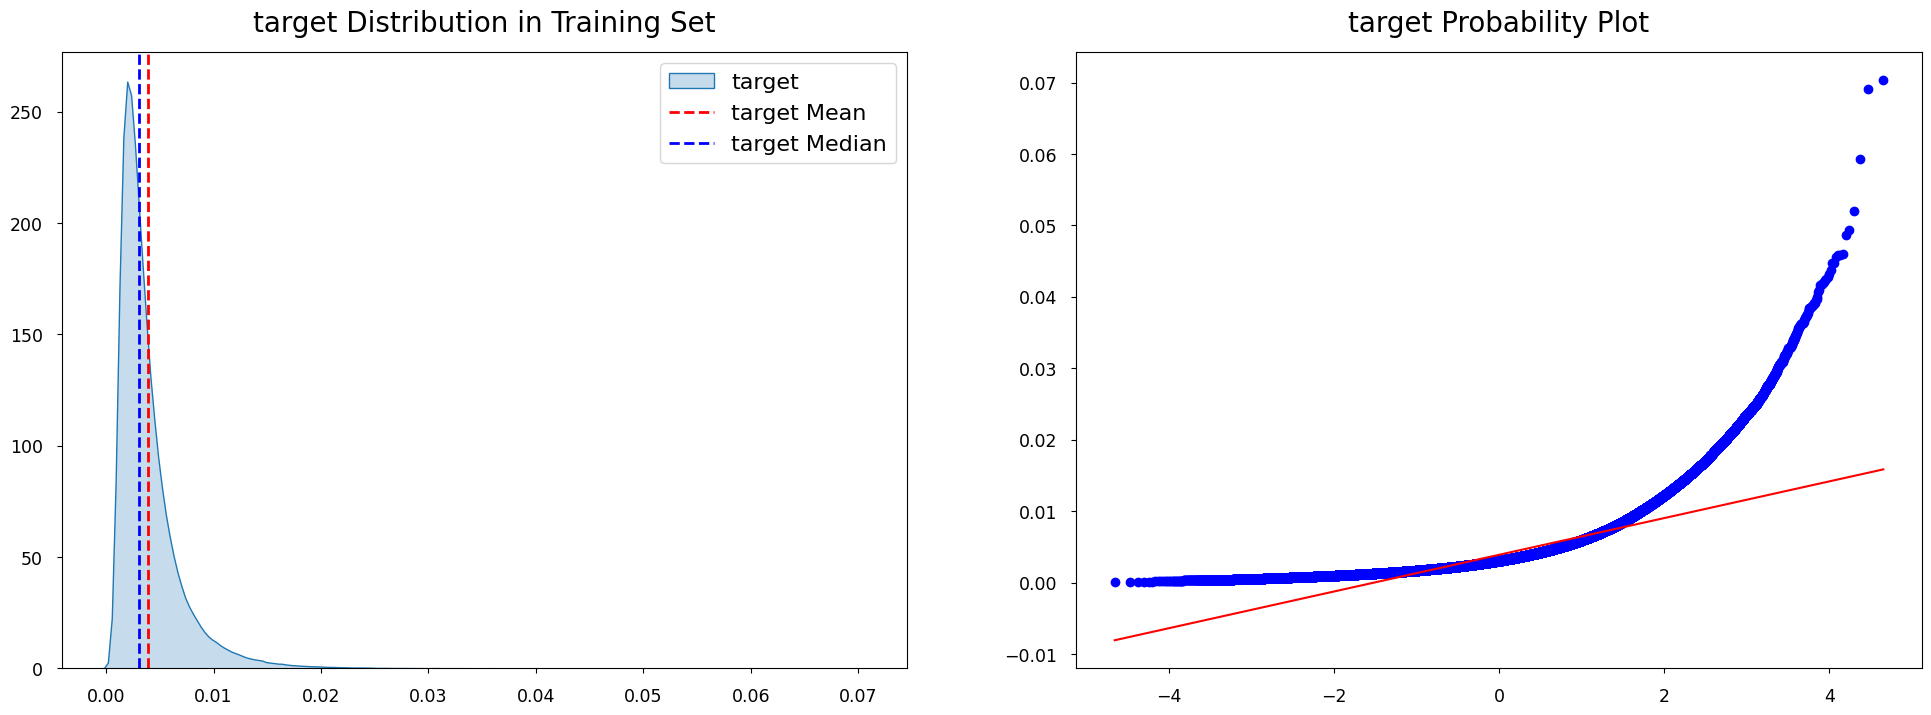

In [15]:
visualize_target('target')

### Vol Range by Stock ID

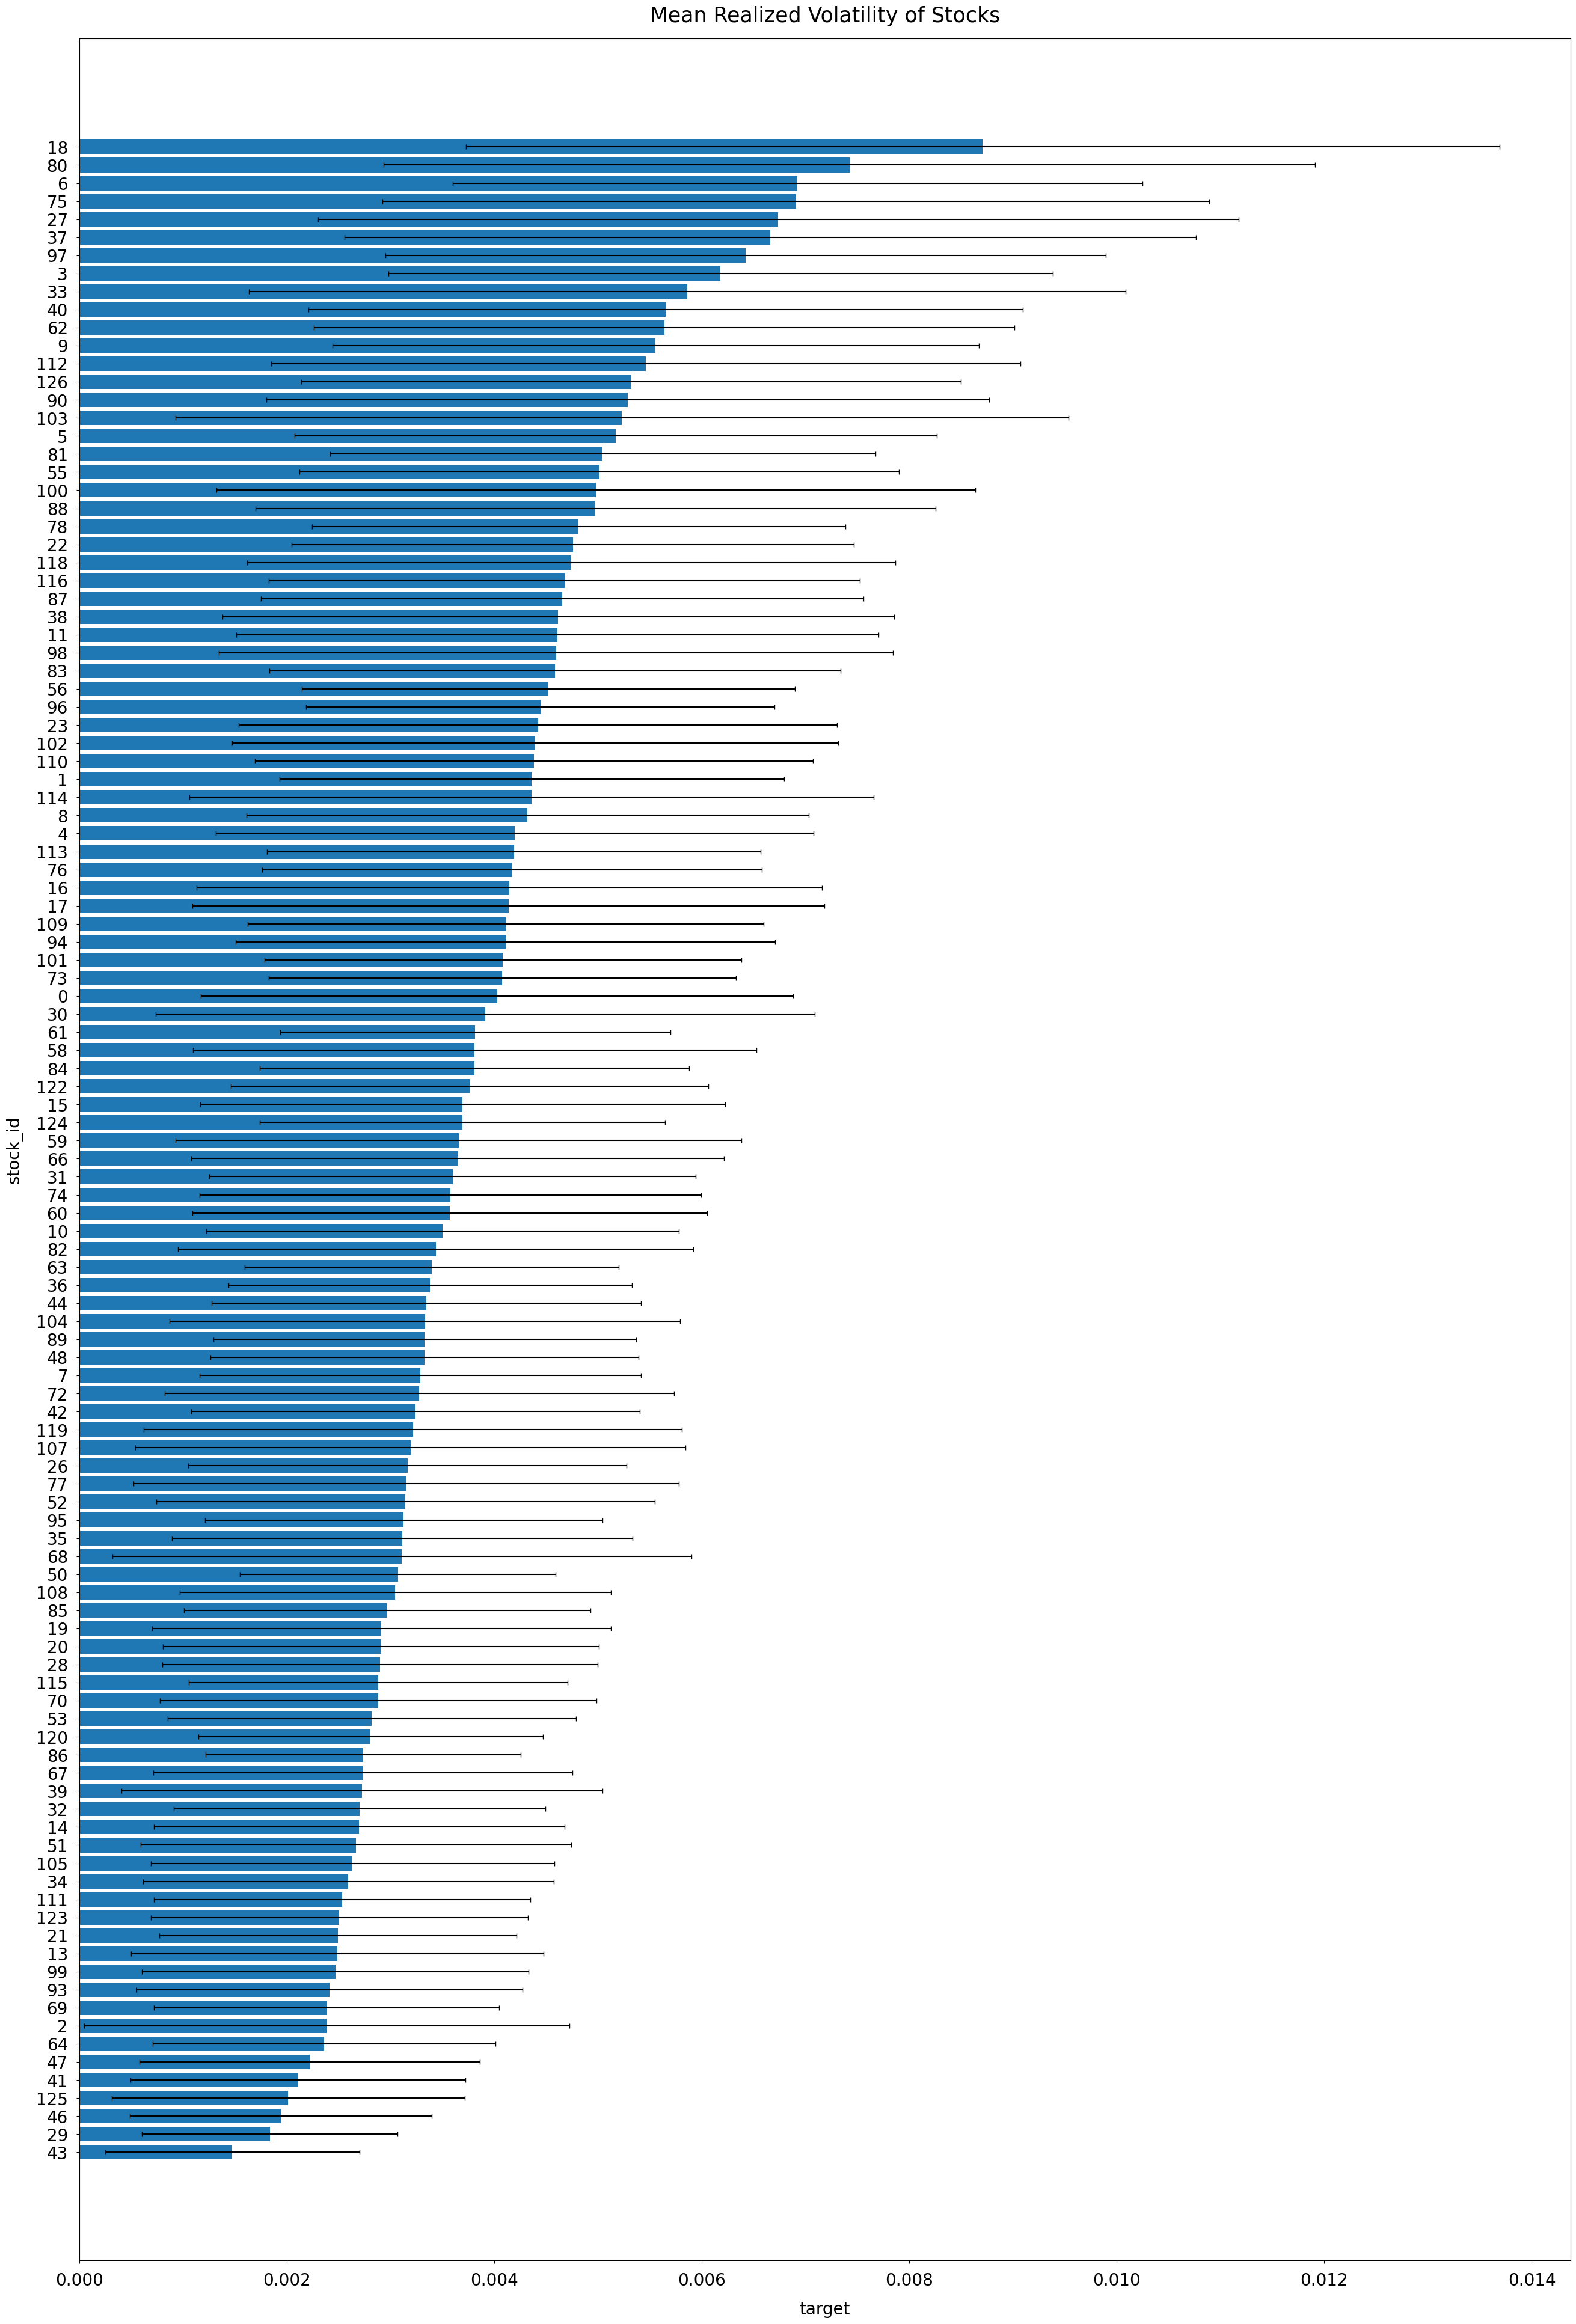

In [16]:
target_means = df_train.groupby('stock_id')['target'].mean()
target_stds = df_train.groupby('stock_id')['target'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

### Vol range by Time bucket (Least/Most)

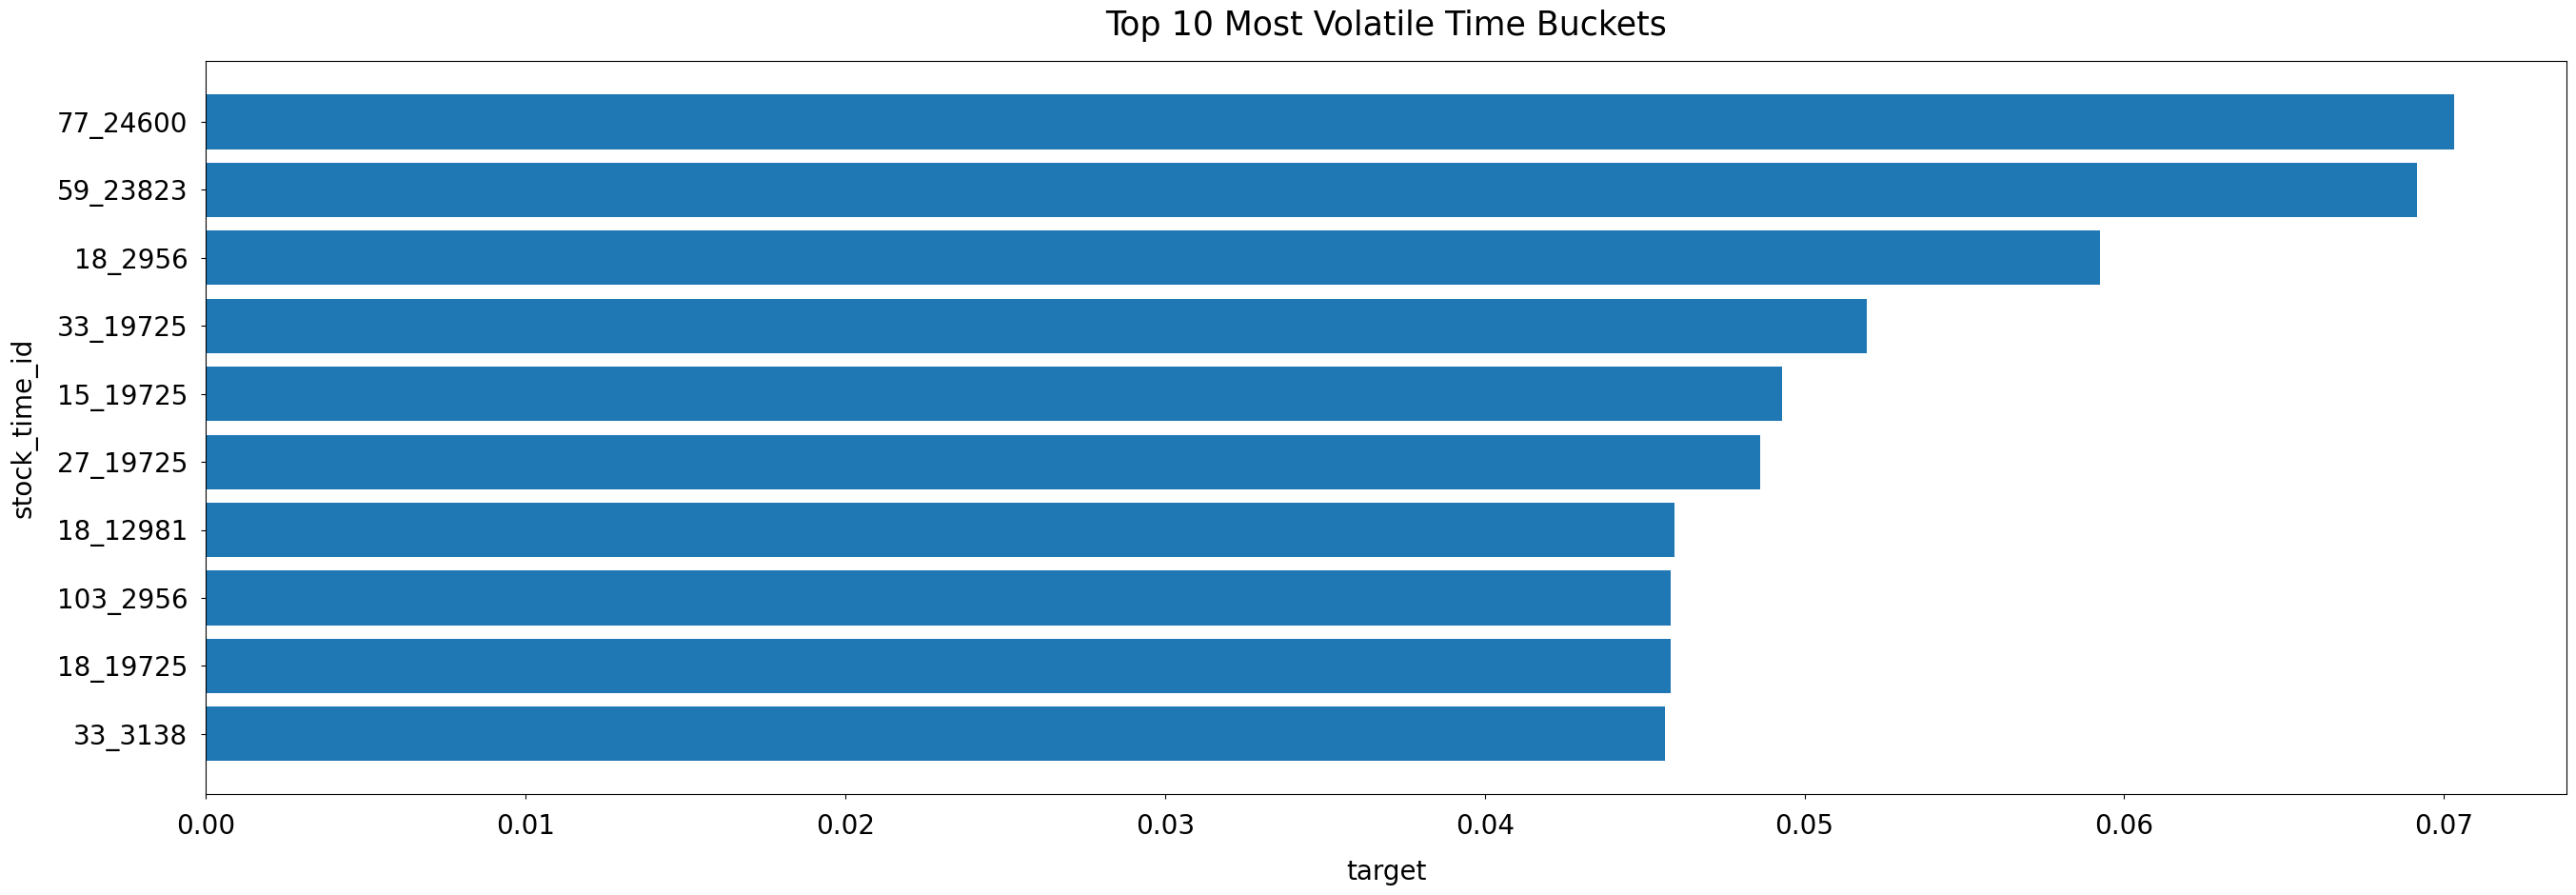

In [17]:
df_train['stock_time_id'] = df_train['stock_id'].astype(str) + '_' + df_train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=df_train.sort_values(by='target', ascending=True).tail(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(df_train.sort_values(by='target', ascending=True).tail(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Most Volatile Time Buckets', size=25, pad=20)

plt.show()

df_train.drop(columns=['stock_time_id'], inplace=True)

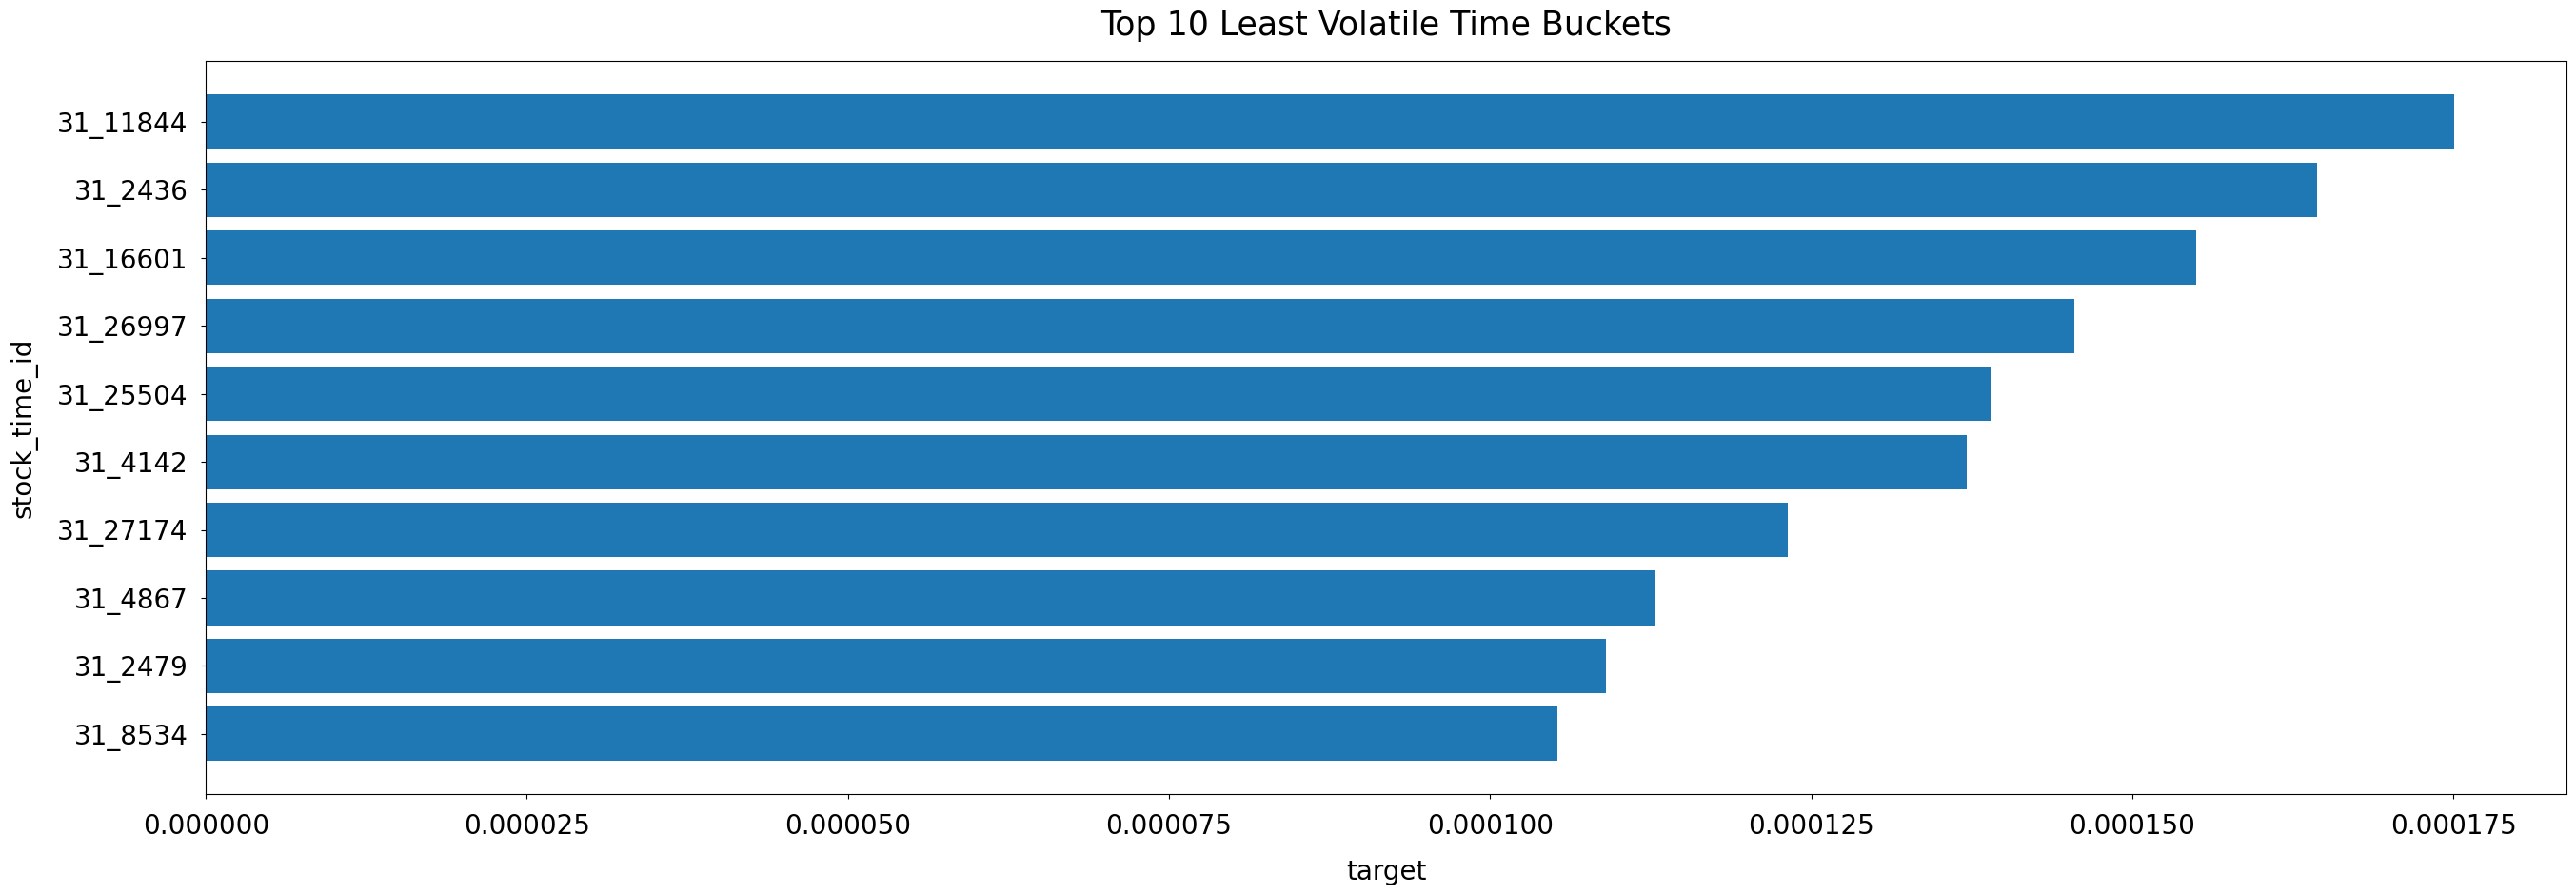

In [18]:
df_train['stock_time_id'] = df_train['stock_id'].astype(str) + '_' + df_train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=df_train.sort_values(by='target', ascending=True).head(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(df_train.sort_values(by='target', ascending=True).head(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Least Volatile Time Buckets', size=25, pad=20)

plt.show()

df_train.drop(columns=['stock_time_id'], inplace=True)

## The Order Book

In [19]:
def read_book_data(dataset, stock_id, sort=False, forward_fill=False):

    book_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'bid_price1': np.float32,
        'ask_price1': np.float32,
        'bid_price2': np.float32,
        'ask_price2': np.float32,
        'bid_size1': np.uint32,
        'ask_size1': np.uint32,
        'bid_size2': np.uint32,
        'ask_size2': np.uint32,
    }

    df_book = pd.read_parquet(f'{data_dir}/book_{dataset}.parquet/stock_id={stock_id}')
    for column, dtype in book_dtypes.items():
        df_book[column] = df_book[column].astype(dtype)

    if sort:
        df_book.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)

    if forward_fill:
        df_book = df_book.set_index(['time_id', 'seconds_in_bucket'])
        df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']), method='ffill')
        df_book.reset_index(inplace=True)

    return df_book

In [20]:
for stock_id in tqdm(sorted(df_train['stock_id'].unique())):

    df_book = read_book_data('train', stock_id)

    # Weighted averaged prices
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])

    # Realized volatilities
    for wap in [1, 2]:
        df_book[f'log_return_from_wap{wap}'] = np.log(df_book[f'wap{wap}'] / df_book.groupby('time_id')[f'wap{wap}'].shift(1))
        df_book[f'squared_log_return_from_wap{wap}'] = df_book[f'log_return_from_wap{wap}'] ** 2
        df_book[f'realized_volatility_from_wap{wap}'] = np.sqrt(df_book.groupby('time_id')[f'squared_log_return_from_wap{wap}'].transform('sum'))
        df_book.drop(columns=[f'squared_log_return_from_wap{wap}'], inplace=True)
        realized_volatilities = df_book.groupby('time_id')[f'realized_volatility_from_wap{wap}'].first().to_dict()
        df_train.loc[df_train['stock_id'] == stock_id, f'realized_volatility_from_wap{wap}'] = df_train[df_train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)

  0%|          | 0/112 [00:00<?, ?it/s]

In [21]:
realized_volatility_wap1_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train['realized_volatility_from_wap1'])
realized_volatility_wap2_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train['realized_volatility_from_wap2'])

print(f'Realized Volatility from WAP1 RMPSE: {realized_volatility_wap1_rmspe:.6}')
print(f'Realized Volatility from WAP2 RMPSE: {realized_volatility_wap2_rmspe:.6}')

Realized Volatility from WAP1 RMPSE: 0.341354
Realized Volatility from WAP2 RMPSE: 0.705453


# NN Model